# A simple autoencoder in PyTorch

**[Faisal Z. Qureshi](http://vclab.science.uoit.ca)**  

Check out excellent PyTorch tutorials by "SherlockLiao" at [https://github.com/L1aoXingyu/pytorch-beginner](https://github.com/L1aoXingyu/pytorch-beginner)

In [73]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

See if have cuda support

In [74]:
for i in range(torch.cuda.device_count()):
    print("Found device:", torch.cuda.get_device_name(i))

if torch.cuda.device_count() == 0:
    print("No GPU device found")
else:
    print("Current cuda device is", torch.cuda.get_device_name(torch.cuda.current_device()))

No GPU device found


## Set up MNIST dataset

For single channel images, don't forget the trailing commas as seen below.

`transforms.Normalize((0.5,),(0.5,))`

We normalize the MNIST images in this manner to ensure that pixel values lie between -0.5 and 0.5.  This allows us to use a sigmoid when predicting pixel values.

In [75]:
batch_size = 16

my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('../datasets', transform=my_transforms, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Lets check out the data

Size of dataset:  60000


Text(0.5, 1.0, 'idx = 7224, Label = 6')

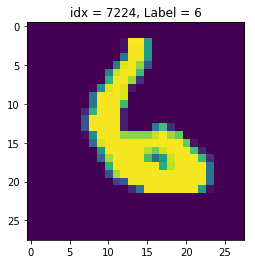

In [78]:
print('Size of dataset: ', len(dataset))
idx = np.random.choice(len(dataset))
x, y = dataset[idx]

plt.figure()
plt.imshow(x.squeeze())
plt.title('idx = {}, Label = {}'.format(idx,y))

Method `to_img` is the opposite of what `Normalize` above does to an MNIST image.

In [79]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## Lets make an autoencoder

In [80]:
class autoencoder(nn.Module):
    
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3))
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), # arbitrary values
            nn.Tanh())               # squished between -1 and 1
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Set up training

In [81]:
learning_rate = 1e-2
weight_decay = 1e-5

if torch.cuda.is_available():
    model = autoencoder().cuda() # Lets put this on Cuda
else:
    model = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

### Now we train

In [82]:
num_epochs = 4

for epoch in range(num_epochs):
    
    for data in dataloader:        
        img, _ = data # img is a [batch_size, num_channels, 28, 28] tensor
                      # here num_channels is 1
            
        img = img.view(img.size(0), -1) # We resize it to [batchsize, 1x28x28] tensor
        
        if torch.cuda.is_available():
            img = Variable(img).cuda() # Lets put this on Cuda
        else:
            img = Variable(img)

        output = model(img) # Forward
        loss = criterion(output, img)

        optimizer.zero_grad() # Backward & update weights
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.data.item()))
    if epoch % 10 == 0:
        pic = to_img(output.cpu().data)
        save_image(pic, 'image_{}.png'.format(epoch))

epoch [1/4], loss:0.1800
epoch [2/4], loss:0.1873
epoch [3/4], loss:0.1770
epoch [4/4], loss:0.1672


## Saving the trained model

Now that training is done, it is a good idea to save the trained model.

We are interested in state_dict dictionary that contains parameters associated with each layer in the model.  Optimizer too has a state_dict.

In [83]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, " -- " , model.state_dict()[param_tensor].size())

Model's state_dict:
encoder.0.weight  --  torch.Size([128, 784])
encoder.0.bias  --  torch.Size([128])
encoder.2.weight  --  torch.Size([64, 128])
encoder.2.bias  --  torch.Size([64])
encoder.4.weight  --  torch.Size([12, 64])
encoder.4.bias  --  torch.Size([12])
encoder.6.weight  --  torch.Size([3, 12])
encoder.6.bias  --  torch.Size([3])
decoder.0.weight  --  torch.Size([12, 3])
decoder.0.bias  --  torch.Size([12])
decoder.2.weight  --  torch.Size([64, 12])
decoder.2.bias  --  torch.Size([64])
decoder.4.weight  --  torch.Size([128, 64])
decoder.4.bias  --  torch.Size([128])
decoder.6.weight  --  torch.Size([784, 128])
decoder.6.bias  --  torch.Size([784])


In [84]:
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name)
    #print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state
param_groups


PyTorch preferred approach to save the model is to use model's state_dict

In [104]:
torch.save(model.state_dict(), 'simple-ae-weights.pt')

## Inference

Now lets pass an image through the learned model and see what we get

torch.Size([1, 28, 28]) 0


Text(0.5, 1.0, 'idx = 0, Label = 0')

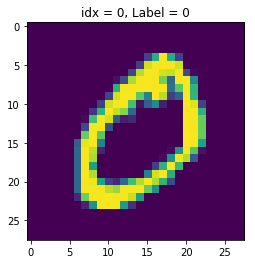

In [105]:
image, label = dataset[1]
print(image.shape, label)

idx = 0
plt.figure()
plt.imshow(image[idx])
plt.title('idx = {}, Label = {}'.format(idx, label))

We now pass this image through the network and see what we get.  We will have to "normalize" and "de-normalize" the data as needed.

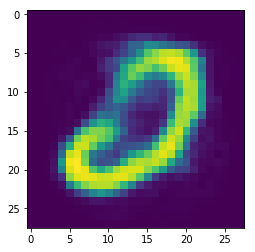

In [106]:
ni = (image - 0.5)/0.5
#print(ni.shape)
ni.unsqueeze_(0)
ni = ni.view(1, -1)
#print(ni.shape)
oi = model(ni)
#print(oi.shape)
oi_ = to_img(oi)
#print(oi_.shape)

plt.imshow(oi_[0,0,:,:].detach())

## Loading the saved model

We can easily load the model as follows

In [107]:
if torch.cuda.is_available():
    model2 = autoencoder().cuda() # Lets put this on Cuda
else:
    model2 = autoencoder()

The following should produce garbage, since we haven't trained the model yet

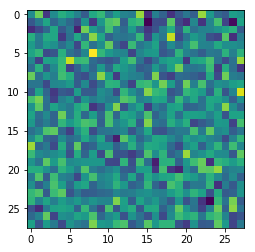

In [108]:
oi = model2(ni)
#print(oi.shape)
oi_ = to_img(oi)
#print(oi_.shape)

plt.imshow(oi_[0,0,:,:].detach())

Now lets load the model and see what happens

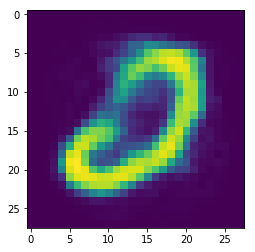

In [109]:
model2.load_state_dict(torch.load('simple-ae-weights.pt'))
oi = model2(ni)
#print(oi.shape)
oi_ = to_img(oi)
#print(oi_.shape)

plt.imshow(oi_[0,0,:,:].detach())

Notice that when you load the model all is well in the world of autoencoders

## Using part of the trained network

Now lets assume we are interested in the **encoder** stage only.  I.e., we want to pass an MNIST image and wants to get its 3-dimensional encoding.  We can do it as follows.

In [110]:
class my_encoder(nn.Module):
    def __init__(self):
        super(my_encoder, self).__init__()
        
        self.features = nn.Sequential(*list(model2.encoder.children())[:])
    
    def forward(self, x):
        x = self.features(x)
        return x

In [111]:
encoder = my_encoder()
encoding = encoder(ni)
print(encoding.detach())

tensor([[ -7.2510,  -6.9455, -18.8368]])


What if we only care about the **decoder** stage.

In [112]:
class my_decoder(nn.Module):
    def __init__(self):
        super(my_decoder, self).__init__()
        
        self.reconstruction = nn.Sequential(*list(model2.decoder.children())[:])
    
    def forward(self, x):
        x = self.reconstruction(x)
        return x

tensor([[1.0000e-02, 1.0000e-04, 1.0000e+00]])
torch.Size([1, 784])


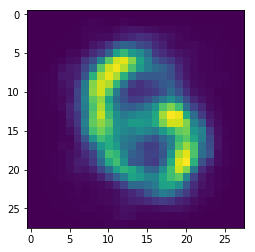

In [113]:
v = torch.empty((1,3))
v[0,0] = 0.01
v[0,1] = 0.0001
v[0,2] = 1
print(v)

d = my_decoder()
ooi = d(v)
print(ooi.shape)
ooi_ = to_img(ooi)
plt.imshow(ooi_[0,0,:,:].detach())
